# WOS 批量论文自动化分析

In [1]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import collections

## 1 数据预处理模块

### 1.1 数据清洗

In [2]:
def data_cleansing(inputFile, outputFile):
    # 读取 xls 文件中的数据
    df = pd.read_excel(f'../data/input/{inputFile}')
    # 删除所有全为缺失值的列
    df = df.dropna(axis=1, how='all')
    # 删除只有列名没有数据的列
    df = df.loc[:, (df.notnull().sum() > 0)]
    # 将 &#8208; 和 &#8211; 都替换为 -
    df = df.replace({'&#8208; ': '-', '&#8211; ': '-'}, regex=True)
    # 将关键词列的分号空格删除
    df[['Author Keywords', 'Keywords Plus']] = df[['Author Keywords', 'Keywords Plus']].replace({'; ': ';'}, regex=True)
    # 将处理过的数据导出到新的 Excel 文件中
    df.to_excel(outputFile, index=False)

In [3]:
inputFile1 = 'vivian.xls'
outputFile1 = '../data/output/vv_wos_cleaned.xlsx'
data_cleansing(inputFile1, outputFile1)

### 1.2 检查清洗数据

In [4]:
df = pd.read_excel(outputFile1)
df.columns

Index(['Publication Type', 'Authors', 'Book Editors', 'Author Full Names',
       'Article Title', 'Source Title', 'Book Series Title', 'Language',
       'Document Type', 'Conference Title', 'Conference Date',
       'Conference Location', 'Conference Sponsor', 'Author Keywords',
       'Keywords Plus', 'Abstract', 'Addresses', 'Affiliations',
       'Reprint Addresses', 'Email Addresses', 'Researcher Ids', 'ORCIDs',
       'Funding Orgs', 'Funding Name Preferred', 'Funding Text',
       'Cited Reference Count', 'Times Cited, WoS Core',
       'Times Cited, All Databases', '180 Day Usage Count',
       'Since 2013 Usage Count', 'Publisher', 'Publisher City',
       'Publisher Address', 'ISSN', 'eISSN', 'ISBN', 'Journal Abbreviation',
       'Journal ISO Abbreviation', 'Publication Date', 'Publication Year',
       'Volume', 'Issue', 'Part Number', 'Supplement', 'Special Issue',
       'Start Page', 'End Page', 'Article Number', 'DOI', 'DOI Link',
       'Early Access Date', 'Number of

### 1.3 核心数据筛选

In [5]:
def coreDataSelect(inputFile, outputFile):
    # 读取 xlsx 文件中的数据
    df = pd.read_excel(inputFile)
    # 筛选出目标表头
    df = df.loc[:, ["Article Title", "Source Title", "Author Keywords",
                    "Keywords Plus", 'Abstract', 'Addresses', "Publication Year", 'DOI']]
    # 将表头进行翻译
    df.columns=["原文标题", "期刊", "作者关键词", "WOS 关键词", "摘要", "地址", "发表年份", "DOI"]
    df.to_excel(outputFile, index=False)

In [6]:
inputFile2 = outputFile1
outputFile2 = '../data/output/vv_core_cleaned.xlsx'
coreDataSelect(inputFile2, outputFile2)

## 2 关键词信息可视化模块

### 2.1 合并关键词列并大写化

In [7]:
# 将所有关键词合并成列表并全部大写化
def all_keywords(inputFile):
    df = pd.read_excel(inputFile)
    # 以分号合并两列关键词内容，并以分号切割成列表
    keywords = df["作者关键词"].str.cat(sep=";") + df["WOS 关键词"].str.cat(sep=";")
    word_list = keywords.split(";")
    # 使用列表推导式和 str.upper () 方法将列表中的字符串全部转换为大写
    word_list_upper = [w.upper() for w in word_list]
    return word_list_upper

### 2.2 关键词同义合并

In [8]:
# 返回合并后的单词列表
def synonymMerge(inputFile):
    word_list = all_keywords(inputFile)
    # 读取映射表
    df = pd.read_excel("../data/input/related_terms.xlsx")
    mapping_dict = dict(zip(df["Original_Word"], df["Mapping_Word"]))
    # 创建一个空列表用于存储转化后的元素
    transformed_list = []
    # 遍历word_list列表中的每个元素
    for word in word_list:
        # 如果元素在字典中有对应的键，则用字典中的值替换它，否则保持不变
        new_word = mapping_dict.get(word, word)
        # 将转化后的元素添加到新列表中
        transformed_list.append(new_word)    
    # 返回合并后的列表类型的数据
    return transformed_list

### 2.3 关键词词频统计

In [9]:
def wordCount(inputFile, outputFile):
    # 同义词替换
    word_list = synonymMerge(inputFile)
    # 使用collections进行词频统计，获取前300个高频词及其出现次数
    # 返回一个字典，键为分词，值为出现次数
    word_counts = collections.Counter(word_list)
    # 返回一个列表，每个元素是一个元组，包含分词和出现次数
    word_counts_top300 = word_counts.most_common(300)
    # 将词频统计的结果导出成新的excel文档
    # 创建一个数据框存放列表数据
    df_word_counts = pd.DataFrame(word_counts_top300, columns=["Keyword", "Count"])
    # 导出数据到excel文件，并去掉索引列
    df_word_counts.to_excel(outputFile, index=False)

In [10]:
inputFile3 = outputFile2
outputFile3 = "../data/output/vv_keyword_counts.xlsx"
wordCount(inputFile3, outputFile3)

### 2.4 关键词词云绘制

In [11]:
from wordcloud import WordCloud, STOPWORDS

In [12]:
# 创建和保存词云图像
def create_wordcloud(word_freq, font_path, output_file):
    wc = WordCloud(
        # width = 300,
        # height = 200,
        background_color = 'white', 
        prefer_horizontal = 1, 
        min_font_size = 2,
        max_font_size = 40,
        font_path = f'../data/fonts/{font_path}', # 使用 f-string 格式化字符串
        scale = 4,
        max_words = 300
        # stopwords = STOPWORDS, # 直接传入停用词集合
        # colormap = 'viridis' # 指定颜色映射
    ).generate_from_frequencies(word_freq)
    plt.figure(figsize=(6,6), dpi=300)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    wc.to_file(f'../data/output/{output_file}')

In [13]:
# 关键词词云
def keywordCloud(inputFile, lang='en'):
    # 读取 xlsx 文件中的数据
    df = pd.read_excel(inputFile)
    # 将数据转换成字典，键为关键词，值为频数
    word_freq = dict(zip(
        df['Keyword' if lang == 'en' else 'Keyword_Translation'],
        df['Count']
    ))
    # 调用函数，生成英文/中文的词云图像
    wc = create_wordcloud(
        word_freq,
        'times.ttf' if lang == 'en' else 'simsun.ttc',
        f'wordcloud_{lang}.png'
    )

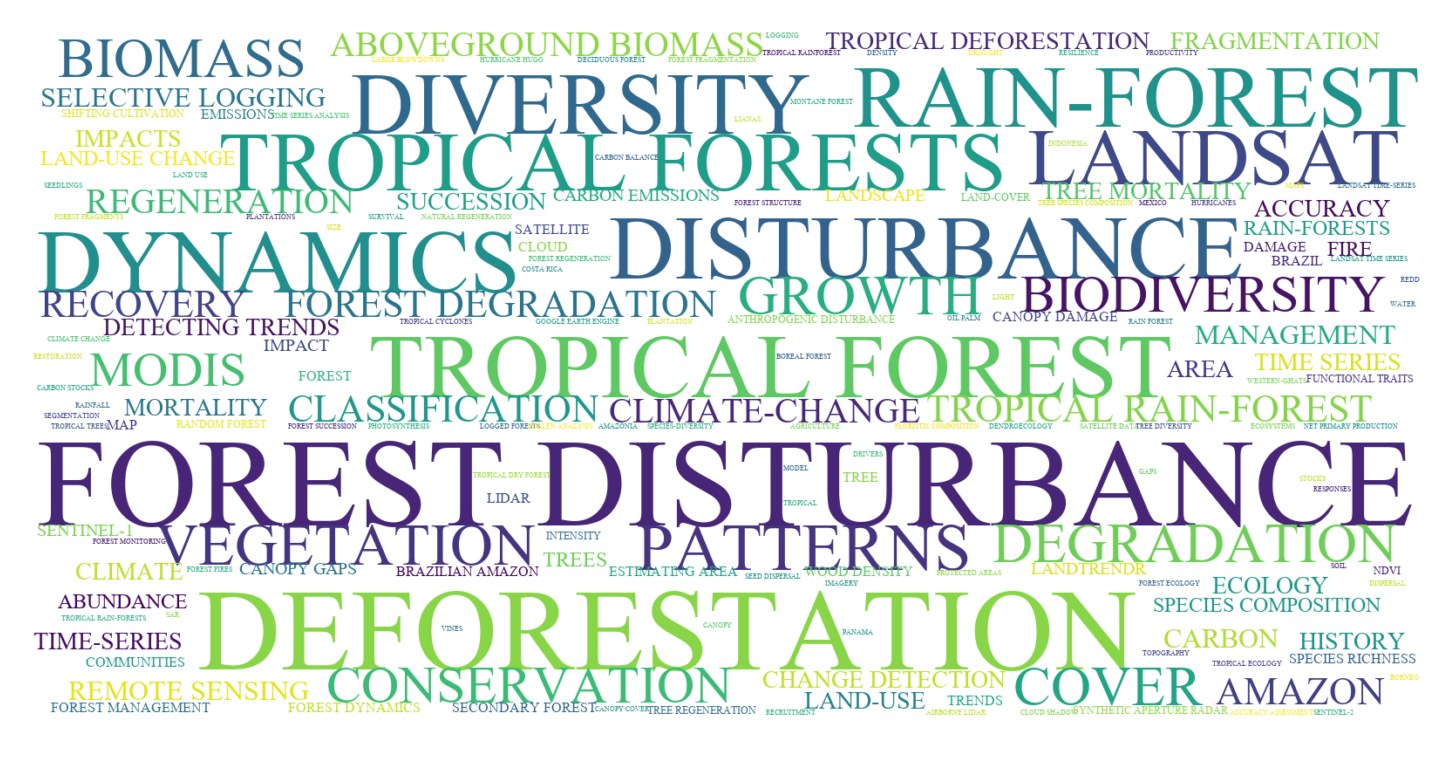

In [14]:
inputFile4 = outputFile3
keywordCloud(inputFile4)

## 3 翻译模块

In [15]:
# 批量翻译
def keywords_tranlate(source_file, source_column, target_file, target_column):
    import tencent_translate
    tencent_translate.write_results(source_file, source_column, target_file, target_column)

In [16]:
# source_file = outputFile2
# target_file = "../data/output/test_tranlate_counts.xlsx"
# keywords_tranlate(source_file, "原文标题", target_file, "标题翻译")

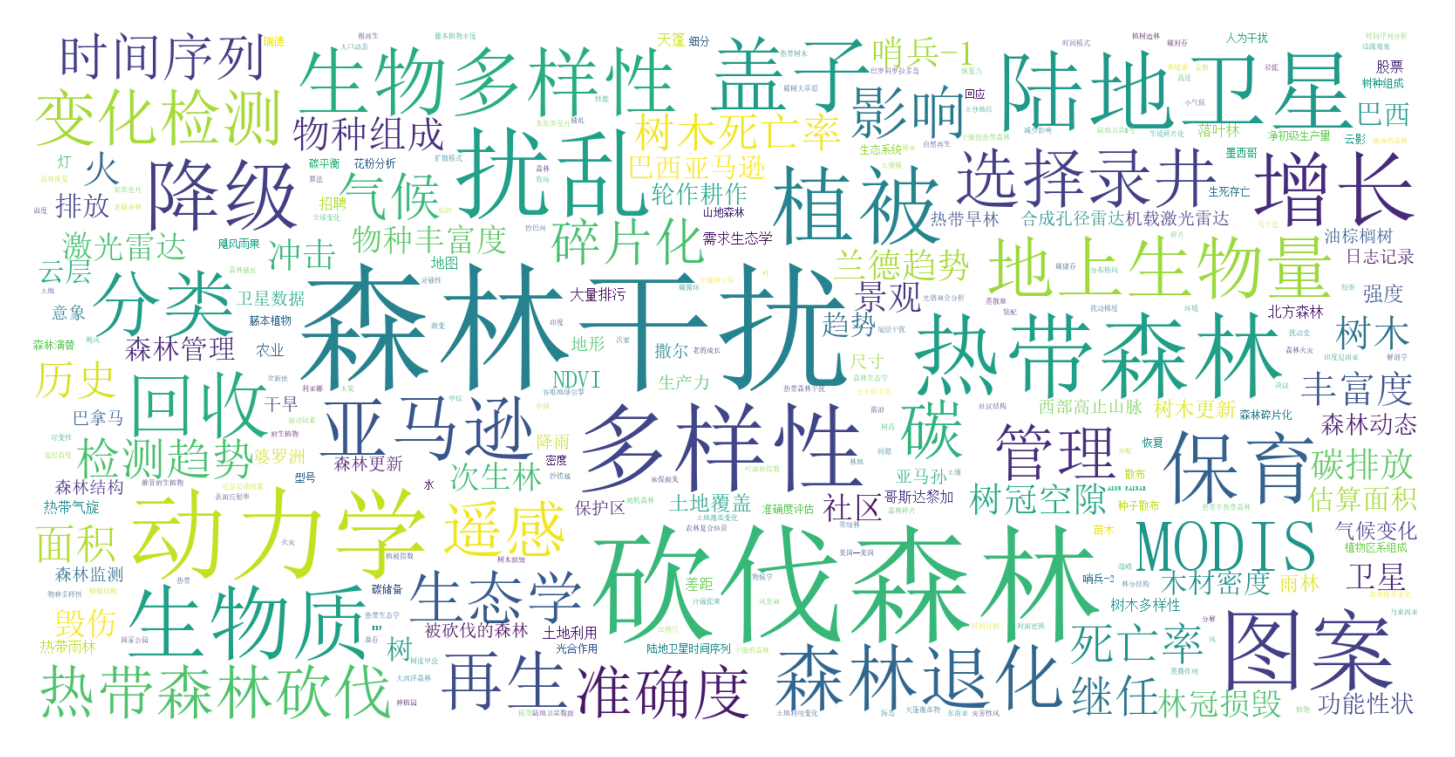

In [17]:
inputFile4 = outputFile3
outputFile4 = "../data/output/vv_keyword_tranlate_counts.xlsx"
keywords_tranlate(inputFile4, "Keyword", outputFile4, "Keyword_Translation")
keywordCloud(outputFile4, lang='zh')